In [ ]:
pip install larq


     |████████████████████████████████| 71kB 3.3MB/s 
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=cb33e0b99135559d916c666726cbb818b6c0a3939af3d525e9e27b09e011984a
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built terminaltables
  Found existing installation: importlib-metadata 3.3.0
    Uninstalling importlib-metadata-3.3.0:
      Successfully uninstalled importlib-metadata-3.3.0


In [ ]:
import larq as larq
import pandas as pd
import numpy as np
import requests
import re
import seaborn
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
r = requests.get(url, allow_redirects=True)
filename = "raw.csv"
open(filename, 'wb').write(r.content)

#load the dataset into memory
dataset = pd.read_csv('raw.csv', header=None, names=['sepal_length','sepal_width','petal_length','petal_width','species'])
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


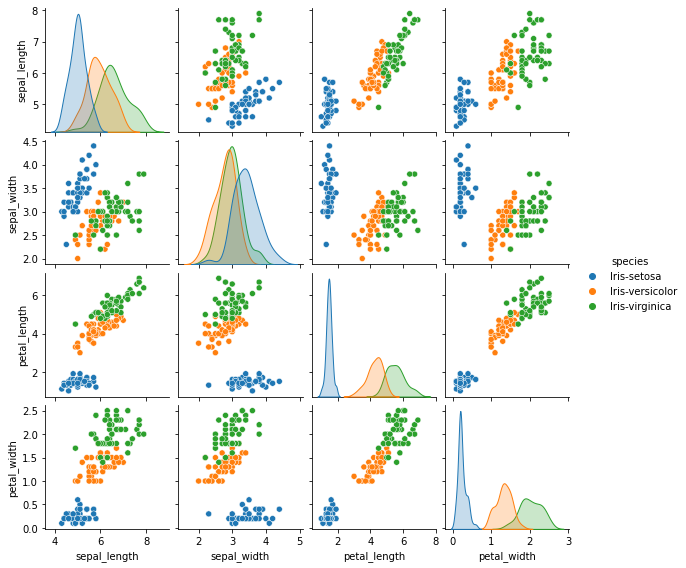

In [ ]:
#Plot the dataset
seaborn.pairplot(dataset, hue="species", height=2, diag_kind="kde")
plt.show()

In [ ]:
from sklearn.preprocessing import LabelBinarizer
species_lb = LabelBinarizer()
Y = species_lb.fit_transform(dataset.species.values)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
FEATURES = dataset.columns[0:4]
X_data = dataset[FEATURES]
scaler = MinMaxScaler(feature_range=(-2, 2))
scaler.fit(X_data)
X_data_normalize=scaler.transform(X_data)

In [ ]:
print(X_data_normalize)

[[-1.11111111e+00  5.00000000e-01 -1.72881356e+00 -1.83333333e+00]
 [-1.33333333e+00 -3.33333333e-01 -1.72881356e+00 -1.83333333e+00]
 [-1.55555556e+00  0.00000000e+00 -1.79661017e+00 -1.83333333e+00]
 [-1.66666667e+00 -1.66666667e-01 -1.66101695e+00 -1.83333333e+00]
 [-1.22222222e+00  6.66666667e-01 -1.72881356e+00 -1.83333333e+00]
 [-7.77777778e-01  1.16666667e+00 -1.52542373e+00 -1.50000000e+00]
 [-1.66666667e+00  3.33333333e-01 -1.72881356e+00 -1.66666667e+00]
 [-1.22222222e+00  3.33333333e-01 -1.66101695e+00 -1.83333333e+00]
 [-1.88888889e+00 -5.00000000e-01 -1.72881356e+00 -1.83333333e+00]
 [-1.33333333e+00 -1.66666667e-01 -1.66101695e+00 -2.00000000e+00]
 [-7.77777778e-01  8.33333333e-01 -1.66101695e+00 -1.83333333e+00]
 [-1.44444444e+00  3.33333333e-01 -1.59322034e+00 -1.83333333e+00]
 [-1.44444444e+00 -3.33333333e-01 -1.72881356e+00 -2.00000000e+00]
 [-2.00000000e+00 -3.33333333e-01 -1.93220339e+00 -2.00000000e+00]
 [-3.33333333e-01  1.33333333e+00 -1.86440678e+00 -1.83333333e

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data_normalize, Y, test_size=0.5, random_state=1)
X_train.shape
#y_train.shape

(75, 4)

In [ ]:
ACCURACY_THRESHOLD = 0.97
# patient early stopping
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if (logs.get('accuracy') > ACCURACY_THRESHOLD) and (logs.get('val_accuracy') > ACCURACY_THRESHOLD) :   
           print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
           self.model.stop_training = True

model = tf.keras.models.Sequential(
    [
        larq.layers.QuantDense(20,input_dim=4,activation='relu',kernel_quantizer="ste_sign", kernel_constraint="weight_clip",bias_constraint=larq.constraints.WeightClip(0.5)),
        larq.layers.QuantDense(3,use_bias=False,activation='sigmoid',input_quantizer=None,kernel_quantizer="ste_sign",kernel_constraint="weight_clip"),
    ]
)
adam=tf.keras.optimizers.Adam(
    learning_rate=0.06, beta_1=0.9, beta_2=0.999, epsilon=5e-06, amsgrad=False,
    name='Adam')
 
model.compile(loss='mean_squared_error',
              optimizer=adam,
              metrics=['accuracy'])

In [ ]:
callback=myCallback()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=400, verbose=2, callbacks=[callback])


Epoch 1/400
5/5 - 0s - loss: 0.3188 - accuracy: 0.5556 - val_loss: 0.1819 - val_accuracy: 0.6000
Epoch 2/400
5/5 - 0s - loss: 0.1438 - accuracy: 0.8074 - val_loss: 0.1059 - val_accuracy: 0.8000
Epoch 3/400
5/5 - 0s - loss: 0.1178 - accuracy: 0.7926 - val_loss: 0.1993 - val_accuracy: 0.6667
Epoch 4/400
5/5 - 0s - loss: 0.1138 - accuracy: 0.8074 - val_loss: 0.1829 - val_accuracy: 0.7333
Epoch 5/400
5/5 - 0s - loss: 0.0923 - accuracy: 0.8593 - val_loss: 0.1267 - val_accuracy: 0.8000
Epoch 6/400
5/5 - 0s - loss: 0.0996 - accuracy: 0.9111 - val_loss: 0.1353 - val_accuracy: 0.8000
Epoch 7/400
5/5 - 0s - loss: 0.0650 - accuracy: 0.8963 - val_loss: 0.1222 - val_accuracy: 0.8000
Epoch 8/400
5/5 - 0s - loss: 0.0804 - accuracy: 0.8593 - val_loss: 0.0790 - val_accuracy: 0.8667
Epoch 9/400
5/5 - 0s - loss: 0.0653 - accuracy: 0.8815 - val_loss: 0.0817 - val_accuracy: 0.8000
Epoch 10/400
5/5 - 0s - loss: 0.0514 - accuracy: 0.9037 - val_loss: 0.0797 - val_accuracy: 0.8000
Epoch 11/400
5/5 - 0s - loss:

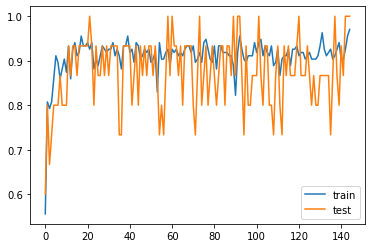

In [ ]:
from matplotlib import pyplot
# plot training history
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
model.evaluate(X_test,y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.0240 - accuracy: 0.9733


[0.02399035543203354, 0.9733333587646484]

In [ ]:

larq.models.summary(model, print_fn=None, include_macs=True)

#新方法是binary的
with larq.context.quantized_scope(True):
    model.save("binary_model.h5")  # save binary weights
    weights = model.get_weights()  # get binary weight
    print(weights)

+sequential_17 stats------------------------------------------------------------+
| Layer           Input prec.   Outputs  # 1-bit  # 32-bit  Memory  32-bit MACs |
|                       (bit)                x 1       x 1    (kB)              |
+-------------------------------------------------------------------------------+
| quant_dense_34            -  (-1, 20)       80        20    0.09           80 |
| quant_dense_35            -   (-1, 3)       60         0    0.01           60 |
+-------------------------------------------------------------------------------+
| Total                                      140        20    0.10          140 |
+-------------------------------------------------------------------------------+
+sequential_17 summary--------------------+
| Total params                   160      |
| Trainable params               160      |
| Non-trainable params           0        |
| Model size                     97.50 B  |
| Model size (8-bit FP weights)  37.50 B  

In [ ]:
model(X_test)

<tf.Tensor: shape=(75, 3), dtype=float32, numpy=
array([[1.0000000e+00, 4.7172482e-19, 3.8634991e-07],
       [9.3428820e-02, 4.5711187e-01, 1.4752269e-02],
       [6.6706419e-02, 7.1445853e-01, 2.8554147e-01],
       [1.0000000e+00, 1.6907178e-17, 1.6581031e-06],
       [2.4866164e-03, 3.4051126e-01, 6.5948874e-01],
       [1.5439144e-01, 5.8257020e-01, 4.1742980e-01],
       [7.4317455e-03, 2.7721375e-02, 9.7227859e-01],
       [1.0000000e+00, 3.4140188e-15, 2.1081009e-06],
       [1.0000000e+00, 5.5776325e-13, 5.6625356e-07],
       [3.6300123e-03, 2.1933734e-02, 9.7806627e-01],
       [1.6035885e-02, 8.8079709e-01, 1.1920291e-01],
       [1.0000000e+00, 3.3388138e-16, 2.1746375e-06],
       [9.9617243e-04, 4.5466065e-02, 9.5453393e-01],
       [1.4858246e-01, 6.6075635e-01, 3.3924365e-01],
       [5.2330703e-02, 5.1788306e-01, 4.8211691e-01],
       [1.0000000e+00, 2.1903598e-14, 3.3106636e-07],
       [1.6275287e-02, 9.3294096e-01, 6.7059040e-02],
       [5.4327041e-02, 6.6075635e

In [ ]:
X_test

array([[-3.33333333e-01,  1.33333333e+00, -1.86440678e+00,
        -1.83333333e+00],
       [-1.11111111e+00, -1.16666667e+00, -6.44067797e-01,
        -3.33333333e-01],
       [ 5.55555556e-01, -3.33333333e-01,  3.05084746e-01,
         1.66666667e-01],
       [-7.77777778e-01,  1.16666667e+00, -1.79661017e+00,
        -1.50000000e+00],
       [ 2.00000000e+00,  1.00000000e+00,  1.66101695e+00,
         1.16666667e+00],
       [ 2.22222222e-01,  1.66666667e-01,  5.08474576e-01,
         5.00000000e-01],
       [ 8.88888889e-01, -1.66666667e-01,  7.79661017e-01,
         1.66666667e+00],
       [-1.11111111e+00,  1.00000000e+00, -1.38983051e+00,
        -1.50000000e+00],
       [-1.55555556e+00,  0.00000000e+00, -1.59322034e+00,
        -1.83333333e+00],
       [ 8.88888889e-01,  0.00000000e+00,  1.18644068e+00,
         1.66666667e+00],
       [-5.55555556e-01, -8.33333333e-01,  1.69491525e-01,
         4.44089210e-16],
       [-7.77777778e-01,  1.16666667e+00, -1.52542373e+00,
      

In [ ]:
y_test

array([[1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0,